In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import gc
import math
import pandas as pd
import numpy as np
import time, multiprocessing
import matplotlib
from glob import glob
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from graspy.plot import heatmap
from scipy import stats
from utils.load_Xy import *
from utils.utils import plot_data,sort_keep_balance
from utils.base_classifiers import get_classifiers,get_names
from optimize_classifiers import optimize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import rerf
gc.enable()

import warnings
warnings.simplefilter('ignore')

In [2]:
def get_data(experiment, data_loader, ns, normalize=True):
    n0 = int(max(ns) / 2)
    n1 = n0
    n_test = 10000

    X_train, y_train, _ = data_loader(n0, n1, ns, seed=0)
    X_test, y_test, size_dict = data_loader(
        int(n_test / 2), int(n_test / 2), ns, seed=1
    )

    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    return(X_train,y_train,X_test,y_test,size_dict)

def get_mnist(ns=None, normalize=True):
    X,y,size_dict = load_mnist_Xy(ns)
    test_size = len(X) - max(ns) 

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=max(ns), test_size=test_size)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    if ns is not None:
        idxs = sort_keep_balance(y_train, ns)
        X_train = X_train[idxs]
        y_train = y_train[idxs]

    return(X_train,y_train,X_test,y_test,size_dict)

## Define Experiment

In [3]:
experiment_metadata = {
    'impulse':[load_impulse_Xy, './timeseries_1d/'],
    'hvbar':[load_hvbar_Xy, './hvbar/'],
    'circle':[load_circle_Xy, './circle_experiment/'],
    'mnist':[load_mnist_Xy, './mnist/'],
}

In [4]:
experiment = 'impulse'
num_runs = 5
save_dir = 'optimization_results'

ncores = 40
n_est = 500

data_loader,root_dir = experiment_metadata[experiment]
write_path = Path(root_dir) / f'{experiment}_results_sklearn.csv'
ns = np.array([10, 50, 100, 200, 400, 1000, 2000])

## Load Data and Params
if experiment == 'mnist':
    ns = [100, 200, 500, 1000, 2500, 5000, 10000, 30000, 60000]
    X_train,y_train,X_test,y_test,size_dict = get_mnist(ns)
else:
    X_train,y_train,X_test,y_test,size_dict = get_data(experiment, data_loader, ns)
imageHeight = size_dict['height']
imageWidth = size_dict['width']
wrap=0

if experiment == 'impulse':
    patch_height_maxs=[1]
    patch_width_maxs=np.arange(2,13,2)
    patch_height_mins=[1]
    patch_width_mins=[2]

elif experiment == 'hvbar':
    patch_height_maxs=[2,3,4,5,7,9]
    patch_width_maxs=[2,3,4,5,7,9]
    patch_height_mins=[2]
    patch_width_mins=[2]

elif experiment == 'circle':
    patch_height_maxs=[1]
    patch_width_maxs=[2,3,4,5,7,9]
    patch_height_mins=[1]
    patch_width_mins=[2]
    wrap=1

elif experiment == 'mnist':
    patch_height_maxs=[2,3,4,5]
    patch_width_maxs=[2,3,4,5]
    patch_height_mins=[2]
    patch_width_mins=[2]
else:
    print("ERROR: Please specify experimental patch sizes")


## Optimize

In [21]:
## Run Optimization
optimize(
    imageWidth=imageWidth,
    imageHeight=imageHeight,
    patch_height_maxs=patch_height_maxs,
    patch_width_maxs=patch_width_maxs,
    patch_height_mins=patch_height_mins,
    patch_width_mins=patch_width_mins,
    wrap=wrap,
    X=X_train[:1000],
    y=y_train[:1000],
    root_dir=root_dir,
    ncores=ncores,
    n_est=n_est,
    save_dir=save_dir,
)

8it [01:44, 27.31s/it]


## Evaluate sklearn algorithms and MORF

In [22]:
## Load default classifiers
names,classifiers = get_classifiers(
                            width=imageWidth,
                            height=imageHeight,
                            ncores=ncores,
                            n_est=n_est,
                            projection_matrix="S-RerF"
                        )

## Load best params
param_dict = {}
for f in glob(str(Path(root_dir) / save_dir / '*.pkl')):
    with open(f, 'rb') as handle:
        d = pickle.load(handle)
        param_dict[d['name']] = d['params']

In [23]:
## Update to best parameters
classifiers = [clf.set_params(**param_dict[name]) for clf,name in zip(classifiers,names)]

In [24]:
# Train each classifier on each dataset size, then test
## Prep output file:
f = open(write_path, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, run) for n in ns\
            for clf in zip(classifiers, [key for key in names])\
            for run in range(num_runs)]

for n, clf, iteration in tqdm(runList):
    trainStartTime = time.time()
    clf[0].fit(X_train[:n], y_train[:n])
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(out, y_test).astype(int))

    ####("variable,Lhat,trainTime,testTime,iterate")
    f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
    f.flush()

f.close()

100%|██████████| 280/280 [04:58<00:00,  3.52s/it]


## Plot

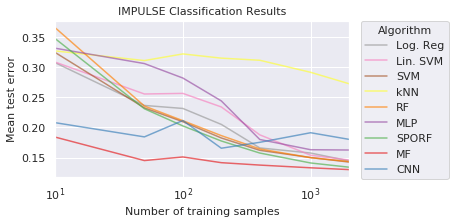

In [13]:
names = get_names()
save_path = None#f'./figures/{experiment}_results.pdf'#
plot_data([write_path, Path(root_dir) / f'{experiment}_results_cnn.csv'],names,title=f'{experiment.upper()} Classification Results', figsize=(6.5,3.25), save_path=save_path)

## Evaluate CNN

In [17]:
from utils.cnn import *

In [32]:
model_dict = {
    'impulse':[ImpulseModel, (1,size_dict['width'])],
    'hvbar':[HVBarModel, (1,size_dict['height'],size_dict['width'])],
    'circle':[CircleModel, (1,size_dict['width'])],
}

In [33]:
## Setup for run
names = {"CNN":"#cab2d6"}
model,shape = model_dict[experiment]
# Hyperparameters
num_epochs = 100
learning_rate = 0.001

classifiers = [
    CNN(model=model,shape=shape,num_epochs=num_epochs, learning_rate=learning_rate, verbose=False)
    ]

In [34]:
# Train each classifier on each dataset size, then test
## Prep output file:
np.random.seed(1234)

write_path = Path(root_dir) / f'{experiment}_results_cnn.csv'
f = open(write_path, 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for run in range(num_runs)]

for n, clf, iteration in tqdm(runList):
    trainStartTime = time.time()
    clf[0].fit(X_train[:n], y_train[:n])
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    testStartTime = time.time()
    yhat = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(yhat, y_test).astype(int))

    ####("variable,Lhat,trainTime,testTime,iterate")
    f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
    f.flush()

f.close()

100%|██████████| 35/35 [00:22<00:00,  1.13it/s]
